In [3]:
library(MCMCpack)
library(mvtnorm)

Warning message:
"package 'MCMCpack' was built under R version 3.6.3"Loading required package: coda
Loading required package: MASS
##
## Markov Chain Monte Carlo Package (MCMCpack)
## Copyright (C) 2003-2021 Andrew D. Martin, Kevin M. Quinn, and Jong Hee Park
##
## Support provided by the U.S. National Science Foundation
## (Grants SES-0350646 and SES-0350613)
##
Warning message:
"package 'mvtnorm' was built under R version 3.6.3"

In [11]:
set.seed(50120057)

In [12]:
z = rmultinom(n = 1,size = 3000, prob=c(0.2,0.3,0.5))

#### random하게 3가지 Class를 확률 prob 에 따라 생성한 결과

#### 이를 활용하여 예제를 위한 데이터셋을 생성하자

In [15]:
y= c(rnorm(n = z[1],mean = -4,sd = 0.7),rnorm(n = z[2], mean= 0, sd = 1.25),rnorm(n = z[3], mean = 4, sd =0.5))

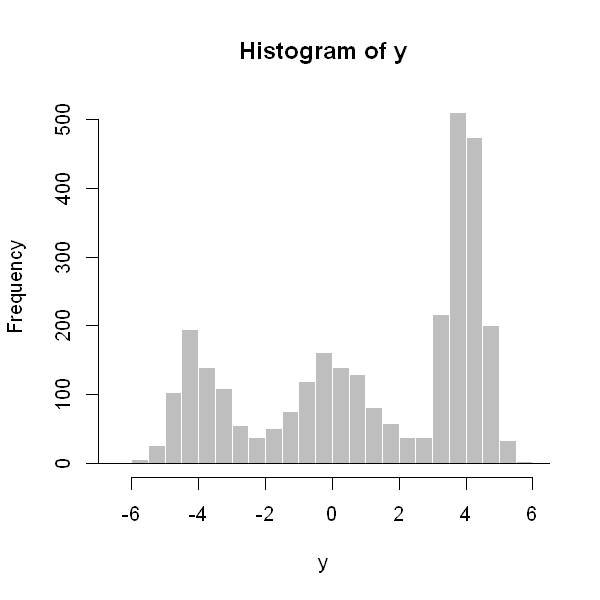

In [28]:
options(repr.plot.width = 5, repr.plot.height = 5)
hist(y, col= "grey", border = "white", breaks = 20)
lines(density(y))

In [24]:
z1_mat = matrix(0,ncol=72, nrow=iter)
z2_mat = matrix(0,ncol=72, nrow=iter)

pi1_mat = matrix(0,ncol=3, nrow=iter)
pi2_mat = matrix(0,ncol=3, nrow=iter)

mu1_mat = matrix(0,ncol=3, nrow=iter)
sig1_mat = matrix(0,ncol=3, nrow=iter)
mu2_mat = matrix(0,ncol=3, nrow=iter)
sig2_mat = matrix(0,ncol=3, nrow=iter)

R=3;K=3
mu1_list = list()
sig1_list = list()
mu2_list = list()
sig2_list = list()
z1_list = list()
z2_list = list()
pi1_list = list()
pi2_list = list()

for(r in 1:3){
  if(r==1){
    pi1_mat[1,] =c(0.5,0.3,0.2)
    pi2_mat[1,] = c(0.5,0.3,0.2)
    z1_mat[1,] = rbinom(len,1,prob=c(pi1_mat[1,]))+1
    z2_mat[1,] = rbinom(len,1,prob=c(pi2_mat[1,]))+1
    mu1_mat[1,] = c(0,0.3,0.6)
    mu2_mat[1,] = c(-1,0,1)
    sig1_mat[1,] = c(0.05,0.05,0.05)
    sig2_mat[1,] = c(0.5,0.5,0.5)
  }
  if(r==2){
    pi1_mat[1,] =c(0.6,0.3,0.1)
    pi2_mat[1,] = c(0.6,0.3,0.1)
    z1_mat[1,] = rbinom(len,1,prob=c(pi1_mat[1,]))+1
    z2_mat[1,] = rbinom(len,1,prob=c(pi2_mat[1,]))+1
    mu1_mat[1,] = c(-0.1,0.3,0.6)
    mu2_mat[1,] = c(-1.5,0.5,1.5)
    sig1_mat[1,] = c(0.07,0.07,0.07)
    sig2_mat[1,] = c(0.7,0.7,0.7)
  }
  if(r==3){
    pi1_mat[1,] = c(0.5,0.4,0.1)
    pi2_mat[1,] = c(0.5,0.4,0.1)
    z1_mat[1,] = rbinom(len,1,prob=c(pi1_mat[1,]))+1
    z2_mat[1,] = rbinom(len,1,prob=c(pi2_mat[1,]))+1
    mu1_mat[1,] = c(-0.3,0.2,0.8)
    mu2_mat[1,] = c(-1.2,0.2,1.2)
    sig1_mat[1,] = c(0.03,0.03,0.03)
    sig2_mat[1,] = c(0.3,0.3,0.3)
  }
  prop_1 = c()
  prop_2 = c()
  
  for(t in 2:iter){
    ### gibbs sampler for z ###
    for(i in 1:len){
      for(k in 1:K){
        prop_1[k] = exp(-1/(2*sig1_mat[t-1,k])*(gene1[i]-mu1_mat[t-1,k])^2)*pi1_mat[t-1,k]
        prop_2[k] = exp(-1/(2*sig2_mat[t-1,k])*(gene2[i]-mu2_mat[t-1,k])^2)*pi2_mat[t-1,k]
      }
      z1_mat[t,i] = which.max(rmultinom(1,1,prop_1/(sum(prop_1))))
      z2_mat[t,i] = which.max(rmultinom(1,1,prop_2/(sum(prop_2))))
    }
    
    ### gibbs sampler for pi ###
    
    pi1_mat[t,] = rdirichlet(1,c(sum(z1_mat[t,]==1)+1/K, sum(z1_mat[t,]==2)+1/K, sum(z1_mat[t,]==3)+1/K))
    pi2_mat[t,] = rdirichlet(1,c(sum(z2_mat[t,]==1)+1/K, sum(z2_mat[t,]==2)+1/K, sum(z2_mat[t,]==3)+1/K))
    
    ### gibbs sampler for mu ###
    
    for(k in 1:K){
      sg1 = (sum(z1_mat[t,]==k)/sig1_mat[t-1,k] + 1/(100^2))^(-1)
      sg2 = (sum(z2_mat[t,]==k)/sig2_mat[t-1,k] + 1/(100^2))^(-1)
      mu1 = (sum(gene1[z1_mat[t,]==k])/sig1_mat[t-1,k])*sg1
      mu2 = (sum(gene2[z2_mat[t,]==k])/sig2_mat[t-1,k])*sg2
      mu1_mat[t,k] = rnorm(1,mu1,sqrt(sg1))
      mu2_mat[t,k] = rnorm(1,mu2,sqrt(sg2))
    }
    
    ### gibbs sampler for sigma ###
    for(k in 1:K){
      sig1_mat[t,k] = rinvgamma(1,0.5*sum(z1_mat[t,]==k)+100,0.5*sum((gene1[z1_mat[t,]==k]-mu1_mat[t,k])^2)+1)
      sig2_mat[t,k] = rinvgamma(1,0.5*sum(z2_mat[t,]==k)+100,0.5*sum((gene2[z2_mat[t,]==k]-mu2_mat[t,k])^2)+1)
    }
  }
  z1_list[[r]] = z1_mat
  z2_list[[r]] = z2_mat
  pi1_list[[r]] = pi1_mat
  pi2_list[[r]] = pi2_mat
  mu1_list[[r]] = mu1_mat
  sig1_list[[r]] = sig1_mat
  mu2_list[[r]] = mu2_mat
  sig2_list[[r]] = sig2_mat
}

par(mfrow=c(3,3))
########################## gene1 #########################
ts.plot(mu1_list[[1]][,1],type="l",xlab="",ylab="",main=expression(mu[1]))
hist(mu1_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(mu[1]))
lines(density(mu1_list[[1]][,1]))
acf(mu1_list[[1]][,1],xlab="",main=expression(mu[1]))
ts.plot(mu1_list[[1]][,2],type="l",xlab="",ylab="",main=expression(mu[2]))
hist(mu1_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(mu[2]))
lines(density(mu1_list[[1]][,2]))
acf(mu1_list[[1]][,2],xlab="",main=expression(mu[2]))
ts.plot(mu1_list[[1]][,3],type="l",xlab="",ylab="",main=expression(mu[3]))
hist(mu1_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(mu[3]))
lines(density(mu1_list[[1]][,3]))
acf(mu1_list[[1]][,3],xlab="",main=expression(mu[3]))

ts.plot(sig1_list[[1]][,1],type="l",xlab="",ylab="",main=expression(sigma[1]^2))
hist(sig1_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(sigma[1]^2))
lines(density(sig1_list[[1]][,1]))
acf(sig1_list[[1]][,1],xlab="",main=expression(sigma[1]^2))
ts.plot(sig1_list[[1]][,2],type="l",xlab="",ylab="",main=expression(sigma[2]^2))
hist(sig1_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(sigma[2]^2))
lines(density(sig1_list[[1]][,2]))
acf(sig1_list[[1]][,2],xlab="",main=expression(sigma[2]^2))
ts.plot(sig1_list[[1]][,3],type="l",xlab="",ylab="",main=expression(sigma[3]^2))
hist(sig1_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(sigma[3]^2))
lines(density(sig1_list[[1]][,3]))
acf(sig1_list[[1]][,3],xlab="",main=expression(sigma[3]^2))

ts.plot(pi1_list[[1]][,1],type="l",xlab="",ylab="",main=expression(pi[1]))
hist(pi1_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(pi[1]))
lines(density(pi1_list[[1]][,1]))
acf(pi1_list[[1]][,1],xlab="",main=expression(pi[1]))
ts.plot(pi1_list[[1]][,2],type="l",xlab="",ylab="",main=expression(pi[2]))
hist(pi1_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(pi[2]))
lines(density(pi1_list[[1]][,2]))
acf(pi1_list[[1]][,2],xlab="",main=expression(pi[2]))
ts.plot(pi1_list[[1]][,3],type="l",xlab="",ylab="",main=expression(pi[3]))
hist(pi1_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(pi[3]))
lines(density(pi1_list[[1]][,3]))
acf(pi1_list[[1]][,3],xlab="",main=expression(pi[3]))


#################### gene2 #######################
ts.plot(mu2_list[[1]][,1],type="l",xlab="",ylab="",main=expression(mu[1]))
hist(mu2_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(mu[1]))
lines(density(mu2_list[[1]][,1]))
acf(mu2_list[[1]][,1],xlab="",main=expression(mu[1]))
ts.plot(mu2_list[[1]][,2],type="l",xlab="",ylab="",main=expression(mu[2]))
hist(mu2_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(mu[2]))
lines(density(mu2_list[[1]][,2]))
acf(mu2_list[[1]][,2],xlab="",main=expression(mu[2]))
ts.plot(mu2_list[[1]][,3],type="l",xlab="",ylab="",main=expression(mu[3]))
hist(mu2_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(mu[3]))
lines(density(mu2_list[[1]][,3]))
acf(mu2_list[[1]][,3],xlab="",main=expression(mu[3]))

ts.plot(sig2_list[[1]][,1],type="l",xlab="",ylab="",main=expression(sigma[1]^2))
hist(sig2_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(sigma[1]^2))
lines(density(sig2_list[[1]][,1]))
acf(sig2_list[[1]][,1],xlab="",main=expression(sigma[1]^2))
ts.plot(sig2_list[[1]][,2],type="l",xlab="",ylab="",main=expression(sigma[2]^2))
hist(sig2_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(sigma[2]^2))
lines(density(sig2_list[[1]][,2]))
acf(sig2_list[[1]][,2],xlab="",main=expression(sigma[2]^2))
ts.plot(sig2_list[[1]][,3],type="l",xlab="",ylab="",main=expression(sigma[3]^2))
hist(sig2_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(sigma[3]^2))
lines(density(sig2_list[[1]][,3]))
acf(sig2_list[[1]][,3],xlab="",main=expression(sigma[3]^2))

ts.plot(pi2_list[[1]][,1],type="l",xlab="",ylab="",main=expression(pi[1]))
hist(pi2_list[[1]][,1],breaks=20,freq=FALSE,xlab="",main=expression(pi[1]))
lines(density(pi2_list[[1]][,1]))
acf(pi2_list[[1]][,1],xlab="",main=expression(pi[1]))
ts.plot(pi2_list[[1]][,2],type="l",xlab="",ylab="",main=expression(pi[2]))
hist(pi2_list[[1]][,2],breaks=20,freq=FALSE,xlab="",main=expression(pi[2]))
lines(density(pi2_list[[1]][,2]))
acf(pi2_list[[1]][,2],xlab="",main=expression(pi[2]))
ts.plot(pi2_list[[1]][,3],type="l",xlab="",ylab="",main=expression(pi[3]))
hist(pi2_list[[1]][,3],breaks=20,freq=FALSE,xlab="",main=expression(pi[3]))
lines(density(pi2_list[[1]][,3]))
acf(pi2_list[[1]][,3],xlab="",main=expression(pi[3]))

ERROR: Error in matrix(0, ncol = 72, nrow = iter): 객체 'iter'를 찾을 수 없습니다
